---
---
---
# CONVOLUTION NEURAL NETWORKS (CNN)
---
---
---

---
---
# CNN İLE KATI ATIK TESPİTİ
---
---

---
1-) Business Problem (İş Problemi)

2-) Data Understanding (Veriyi Anlamak)

3-) Data Preparation (Veriyi Hazırlamak)

4-) Modelling (Modelleme)

5-) Evalation (Değerlendirme)

6-) Saving Model and Using it to Predict (Modelin Kaydedilmesi ve Tahmin İçin Kullanılması)

---

1-) Business Problem (İş Problemi)

* Plastik
* Karton
* Cam
* vb...

2-) Data Understanding (Veriyi Anlamak)

2.1-) Data Understanding (Veriyi Anlamak)

![](CNN_Story_Of_The_Dataset.png)

In [1]:
# GEREKLİ KÜTÜPHANELER

# Veriyi Okuma ve işleme için;
import cv2
import urllib
import numpy             as np
import pandas            as pd
import seaborn           as sns
import random
import os
import glob
from imutils        import paths
import matplotlib.pyplot as plt
from sklearn.utils  import shuffle
from urllib.request import urlopen

# Warning kapatmak için;
import warnings
warnings.filterwarnings("ignore")

# Model Değerlendirme için;
from sklearn.metrics import confusion_matrix,classification_report

# Model için;
import tensorflow as tf
from tensorflow.keras.models              import Sequential
from tensorflow.keras.preprocessing       import image
from tensorflow.keras.utils               import to_categorical
from tensorflow.keras.callbacks           import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers              import Conv2D,Flatten,MaxPooling2D,Dense,Dropout,SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img,array_to_img

2.2) Data Reading

In [2]:
# Veri setinde yer alan görüntülerin olduğu path bilgisi
folder_path = "Garbage_classification"

# Target Size ve Label etiket değerlerinin belirlenmesi

target_size  = (224, 224)

waste_labels = {"cardboard":0,
                "glass"    :1,
                "metal"    :2,
                "paper"    :3,
                "plastic"  :4,
                "trash"    :5}

In [3]:
#veri setini okuyacak fonksiyon: #google colab ile de çalışır
def load_datasets(path):
    """
    Görsellerin bulunduğu dizindeki görüntüyü okuyup etiketlerini oluşturur.
    Parametreler:
    path: görsellerin bulunduğu dizin
    return:
    x: görüntülere ait matris bilgileri
    labels: görüntülere ait sınıf bilgileri 
    """
    x      = []
    labels = []

    # gönderdiğimiz pathdeki görüntüleri listeleyip sıralar:
    image_paths = sorted(list(paths.list_images(path)))

    for image_path in image_paths:
        # Belirtilen pathdeki görüntüler openCV ile okunur
        img = cv2.imread(image_path)
        # Okunan görüntüler belirlenen target size'a göre yeniden ölçeklendirilir.
        img = cv2.resize(img,target_size)
        # Ölçeklendirilen görüntüler x listesine eklenir.
        x.append(img)
        # Her bir path '/' ifadesi ile ayrıldığında dönen listenin sondan 2. elamnı labeli temsil eder.
        label = image_path.split(os.path.sep)[-2]
        # Yakalanaan labelların sayısal değer karşılıklarının 
        # olduğu waste_labels sözlüğü içiniden gönderilen key değerine 
        # karşılık value değeri alınarak label oluşturulur.
        labels.append(waste_labels[label])
    
    # Veri seti rarndom bir şekilde karıştırılır.
    # Görüntüler karışık değil, kartonlar klasörü, 
    # camlar klasörü, vb. şeklinde aynı veriler arka arkaya aldık.
    x, labels = shuffle(x, labels, random_state=42)

    # Boyut ve Sınıf bilgisi raporları:
    print(f"X boyutu: {np.array(x).shape}")
    print(f"Label sınıf sayısı: {len(np.unique(labels))} Gözlem sayısı: {len(labels)}")

    return x, labels

In [4]:
x, labels = load_datasets(folder_path)

X boyutu: (2527, 224, 224, 3)
Label sınıf sayısı: 6 Gözlem sayısı: 2527


In [5]:
x

[array([[[249, 255, 254],
         [249, 255, 254],
         [249, 255, 254],
         ...,
         [205, 218, 226],
         [205, 218, 226],
         [203, 215, 224]],
 
        [[249, 255, 254],
         [249, 255, 254],
         [249, 255, 254],
         ...,
         [205, 218, 226],
         [205, 218, 226],
         [202, 216, 223]],
 
        [[247, 255, 254],
         [247, 255, 254],
         [247, 255, 254],
         ...,
         [205, 218, 226],
         [205, 218, 226],
         [202, 215, 223]],
 
        ...,
 
        [[211, 228, 237],
         [210, 227, 236],
         [209, 226, 235],
         ...,
         [178, 194, 201],
         [178, 194, 201],
         [178, 194, 201]],
 
        [[211, 228, 237],
         [210, 227, 236],
         [209, 226, 235],
         ...,
         [178, 194, 201],
         [178, 194, 201],
         [178, 194, 201]],
 
        [[211, 228, 237],
         [210, 227, 236],
         [209, 226, 235],
         ...,
         [178, 194, 201],
  

In [6]:
# Görüntü boyutlarının tutulması
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
print(input_shape)

(224, 224, 3)


2.3-) Veri Setinden Örnekleri Gösterme

In [7]:
def visualize_img(image_batch, label_batch):
    """     
    Veri seti iöerisinden görüntü görselleştirir.
    Parametreler:
    image_batch : Görüntülerin matris bilgilerini tutar
    label_batch : Görüntünün ait olduğu sınıf bilgisini tutan liste. 
    """

    plt.figure(figsize=(10,10))
    for n in range(10):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels,num_classes=6)[n]==1][0].title())
        plt.axis("off")

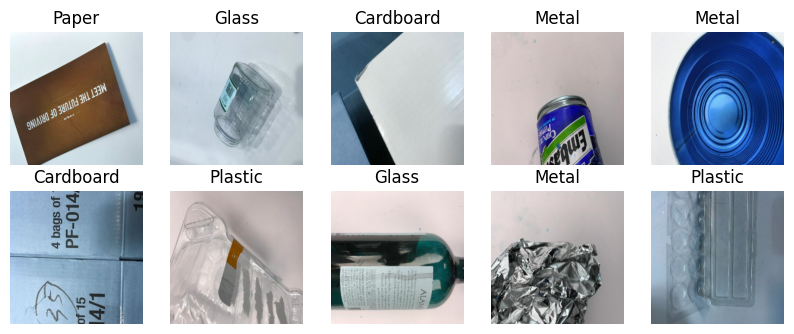

In [8]:
visualize_img(x,labels)

3-) Data Preparation (Veriyi Hazırlamak)

Data preproccessing + Data augmentation

In [9]:
# Data Augmentation, Veri arttırma, Gürültü ekleme

# Train veri seti için bir generator tanımlıyoruz.
train = ImageDataGenerator(horizontal_flip      = True,  #rastgele yatay çevir
                           vertical_flip        = True,  #rastgele dikey çevir
                           validation_split     = 0.1,   #test veri setinin oranı
                           rescale              = 1./255,#rescale yeniden ölçeklendir. Normalleştirme. 0-1 arasına.
                           zoom_range           = 0.1,   #görüntünün şekline eğim verme (saat yönünün tersine göre)
                           width_shift_range    = 0.1,   #yatay kaydırma
                           height_shift_range   = 0.1)   #dikey kaydırma

# Test veri seti için bir generator tanımlıyoruz.
test = ImageDataGenerator(rescale           = 1./255,
                          validation_split  = 0.1)

In [10]:
train_generator = train.flow_from_directory(directory   = folder_path,   #resimlerin dizini
                                            target_size = (target_size), #boyutlarını ölçeklendirmek için kullanacağımız boyut bilgisi
                                            class_mode  = "categorical", #ilgilenilen ckategorik değişkenin sınıfını ifade eder. categorical=2'den fazla sınıf
                                            subset      = "training")    #ImageDateGenerator()'da validation_split kullanılmış ise
                                                                         #Verinin alt kümesinden "training" veya "validation" diye belirtilmeli.

test_generator  = test.flow_from_directory(directory    = folder_path,
                                           target_size  = (target_size),
                                           batch_size   = 251,           #veri gruplarının boyutu
                                           class_mode   = "categorical",
                                           subset       = "validation")

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


4-) Modelling (Modelleme)

4.1-) Sıfırdan CNN Modeli Kurma
- Sequential (Sıralı katmanlardan oluşan sinir ağı kurma yöntemi)
- Convolution Layer, Conv2D (Evrişim)
- Pooling     Layer (Havuzlama)
- Activation  Layer (Aktivasyon Fonksiyonu)
- Flattening  Layer (Tam Bağlantı) (Düzleştirme) (Matrix'i string yapma)
- Dense       Layer 
- Dropout     Layer (Sönümleme)

![](Convolutional_Neural_Network.png)

![](CNN_architecture.png)

In [14]:
#Modeli sıralı katmanlardan oluşacak diye başlatma ve layerları ekleme
model = Sequential()
#Convolution Layer                              #Giriş katmanından öznitelik çıkartma katmanı
model.add(Conv2D(filters=32,                    #Görüntü üzerinde gezdirilecek olan filtre sayısı.
                 kernel_size=(3,3),             #Filtrelerin boyutları.
                 padding="same",                #Çıkış matrisi boyutu = giriş matrisi boyutu olacak şekilde girdininin kenarlarına eşit olacak şekilde 0 pixel değerleri yerleştirir.
                 input_shape=(input_shape),     #Giriş görüntülerinin boyut bilgileri
                 activation="relu"))            #Activasyon fonksiyonu #activasyon katmanı bilgisi burada ifade edildi.
#Pooling Layer                            #Görüntünün özelliklerini kaybetmeden boyutunu azaltmak.   
model.add(MaxPooling2D(pool_size=2,       #MaxPooling yapılmış matrisin boyutu
                       strides=(2,2)))    #

#Convolution Layer
model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 padding="same",
                 activation="relu"))
#Pooling Layer
model.add(MaxPooling2D(pool_size=2,
                       strides=(2,2)))
#Convolution Layer
model.add(Conv2D(filters=32,
                 kernel_size=(3,3),
                 padding="same",
                 activation="relu"))
#Pooling Layer
model.add(MaxPooling2D(pool_size=2,
                       strides=(2,2)))
#Flatten layer          #Giriş verilerindeki matrix'leri tek boyutlu dizi yapar.
model.add(Flatten())
#Dense Layer    #Bir katmandaki nöronlardan aldığı bilgilerin, bir sonraki katmana girdi olarak bağlanmasını sağlar.
model.add(Dense(units=64,           #units: nöron sayısı
                activation="relu"))
